In [2]:
!pip install auto-sklearn==0.14.3
# run this first, then restart runtime, then run everything below

In [3]:
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import seaborn as sns

import string
from urllib.parse import urlparse
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import preprocessing as tfkp
from tensorflow.keras.utils import to_categorical

import gensim.downloader as api
from imblearn.over_sampling import RandomOverSampler

#if on Google Colab, put the DL_model files in root
from DL_models import lstm_keras, cnn_keras, blstm, blstm_att

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def indiv_eval(model, X_test, y_test, target_names=['Normal', 'Cyberbullying']):
    preds_probs = model.predict(X_test)
    preds = [np.argmax(p) for p in preds_probs]

    print(classification_report(y_test, preds))

    plt.figure()
    sns.heatmap(confusion_matrix(y_test, preds, normalize='true'), fmt='.2%', annot=True ,linewidths=.5,cmap='YlOrRd', annot_kws={"fontsize":10}, yticklabels=target_names, xticklabels=target_names)
    plt.xticks(rotation=45, ha='right')

    plt.show()

    return preds

In [5]:
from mlxtend.evaluate import cochrans_q
from mlxtend.evaluate import mcnemar
from mlxtend.evaluate import mcnemar_tables
from prettytable import PrettyTable

def model_compare(key, model_list):

    two_models = key.split(' vs ')
    first_model = int(two_models[0].split('_')[-1])
    second_model = int(two_models[1].split('_')[-1])

    return model_list[first_model], model_list[second_model]

def multiple_mcnemar(model_name_list, preds_array, y, sig_level):

    # creates the 'correct' value for use in the McNemar table
    y_true = np.array([1] * len(y))

    converted_pred_array = []

    for i in range(len(preds_array)):
        converted_pred_array.append((preds_array[i]==y).astype(int))

    '''q, p_value = cochrans_q(y_true,*converted_pred_array)

    significance = p_value < sig_level

    scientific_notation="{:.2e}".format(p_value)

    print(f"-----Cochran's Q Test-----")
    print(f'============================')
    print(f'Q-Score         {q:.4f}')
    print(f'p-value         {scientific_notation}')
    print(f'Reject? ({1-sig_level:.0%})      {significance}')
    print('\n')'''

    mctable = mcnemar_tables(y_true, *converted_pred_array)

    pairwise_table = PrettyTable()
    pairwise_table.field_names = ['Model 1', 'Model 2', 'Chi²', 'p-Value', 'Reject?']

    for key, value in mctable.items():
        chi2, p = mcnemar(ary=value, corrected=True)
        first_model, second_model = model_compare(key, model_name_list)
        reject_null = p < sig_level

        pairwise_table.add_row([first_model, second_model, chi2, p, reject_null])
        pairwise_table.float_format["Chi²"] = '.2E'
        pairwise_table.float_format["p-Value"] = '.2E'

    print(pairwise_table)

In [6]:
# embedding stuff
def map_weights(embed_dict, vocab, embed_size): # embed size is embedding dim
    vocab_size = len(vocab) + 1
    weights = np.zeros((vocab_size, embed_size))

    n_missed = 0
    words_missed = []
    for k,v in vocab.items():
        try:
            weights[v] = embed_dict[k]  # weights[v] is an index, embed_dict[k] is the list of weights
        except:
            n_missed += 1
            words_missed.append(k)
    print(f"{n_missed} embeddings missed of {vocab_size}")
    return weights, words_missed

### Loading Data

In [7]:
dataset = 'wiki'

comments = pd.read_csv('/content/drive/MyDrive/Uni/Experiment Design/Ass2/preprocessing/WikiPages/wikipedia_preprocessed.csv')

x_text = list(comments['comment'])
labels = list(comments['attack'])

labels, uniques = pd.factorize(labels)

### Intitial Twitter-Specific Pre-processing

In [8]:
import re
comments = pd.DataFrame({'comment': x_text, 'attack': labels})

#drop nulls
comments = comments[comments['comment'].notna()]

#lower case
comments['comment'] = comments['comment'].str.lower()

#remove stop words
comments['comment'] = comments['comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords.words('english')]))

#tokenize
#comments['comment'] = comments.apply(lambda row: nltk.word_tokenize(row['comment']), axis=1)

#remove punctiations
#comments['comment'] = [list(filter(lambda x: x not in string.punctuation, sentence)) for sentence in comments['comment']]

In [9]:
comments.head()

,comment,attack
0,creative dictionary definitions terms insuranc...,0
1,term standard model less npov think wed prefer...,0
2,true false situation march 2002 saudi proposal...,0
3,next maybe could work less condescending sugge...,0
4,page need disambiguation,0


### Train-Test Split and Tokenization

In [10]:
X_train_pretoken, X_midway_pretoken, y_train, y_midway = train_test_split(comments['comment'], comments['attack'], random_state = 42, test_size=0.2)

In [11]:
comments['number_of_words'] = comments.comment.apply(lambda x: len(x.split()))

In [12]:
comments['number_of_words'].quantile(0.95)

107.0

In [13]:
dim = 100 #manually set to 95th percentile
n_classes = len(np.unique(y_train.values))

tokenizer = tfkp.text.Tokenizer(oov_token="<UNK>", filters='!"$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',)
tokenizer.fit_on_texts(X_train_pretoken)

convert = lambda x: tfkp.sequence.pad_sequences(tokenizer.texts_to_sequences(x),
                                                    maxlen=dim,
                                                    padding='post', truncating='post')

X_train = convert(X_train_pretoken)
X_midway = convert(X_midway_pretoken)

In [14]:
X_test, X_val, y_test, y_val = train_test_split(X_midway, y_midway, random_state = 42, test_size=0.5)

### Oversampling

In [15]:
oversample = RandomOverSampler(random_state=42)
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

### Reshaping for input

In [16]:
y_train_onehot = to_categorical(y_train, n_classes)
y_val_onehot = to_categorical(y_val, n_classes)
y_test_onehot = to_categorical(y_test, n_classes)
y_train_over_onehot = to_categorical(y_train_over, n_classes)

#### Fast Load DL Models

In [1]:
# Fast load DL models
import keras
import shutil
from keras.models import Sequential

lstm_random = Sequential()
lstm_random_over = Sequential()
lstm_glove = Sequential()
lstm_glove_over = Sequential()
lstm_word2vec = Sequential()
lstm_word2vec_over = Sequential()

blstm_random = Sequential()
blstm_random_over = Sequential()
blstm_glove = Sequential()
blstm_glove_over = Sequential()
blstm_word2vec = Sequential()
blstm_word2vec_over = Sequential()

blstm_att_random = Sequential()
blstm_att_random_over = Sequential()
blstm_att_glove = Sequential()
blstm_att_glove_over = Sequential()
blstm_att_word2vec = Sequential()
blstm_att_word2vec_over = Sequential()

cnn_random = Sequential()
cnn_random_over = Sequential()
cnn_glove = Sequential()
cnn_glove_over = Sequential()
cnn_word2vec = Sequential()
cnn_word2vec_over = Sequential()

model_list = [lstm_random,
lstm_random_over,
lstm_glove,
lstm_glove_over,
lstm_word2vec,
lstm_word2vec_over,
blstm_random,
blstm_random_over,
blstm_glove,
blstm_glove_over,
blstm_word2vec,
blstm_word2vec_over,
blstm_att_random,
blstm_att_random_over,
blstm_att_glove,
blstm_att_glove_over,
blstm_att_word2vec,
blstm_att_word2vec_over,
cnn_random,
cnn_random_over,
cnn_glove,
cnn_glove_over,
cnn_word2vec,
cnn_word2vec_over]

model_name_list = ['lstm_random',
'lstm_random_over',
'lstm_glove',
'lstm_glove_over',
'lstm_word2vec',
'lstm_word2vec_over',
'blstm_random',
'blstm_random_over',
'blstm_glove',
'blstm_glove_over',
'blstm_word2vec',
'blstm_word2vec_over',
'blstm_att_random',
'blstm_att_random_over',
'blstm_att_glove',
'blstm_att_glove_over',
'blstm_att_word2vec',
'blstm_att_word2vec_over',
'cnn_random',
'cnn_random_over',
'cnn_glove',
'cnn_glove_over',
'cnn_word2vec',
'cnn_word2vec_over']

for model in model_list:
    index = model_list.index(model)
    model_name = model_name_list[index]
    print(model_name)
    #shutil.unpack_archive(f'/content/drive/MyDrive/Uni/Experiment Design/Ass2/Deep Learning/models_wiki/{model_name}.zip', f'/content/{model_name}/')
    model_list[index] = keras.models.load_model(f'/content/{model_name}/')

lstm_random
lstm_random_over
lstm_glove


Exception ignored in: <function ScopedTFGraph.__del__ at 0x7f45d01137a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/c_api_util.py", line 57, in __del__
    def __del__(self):
KeyboardInterrupt


KeyboardInterrupt: ignored

### Glove Embedding Weights

In [ ]:
glove_dict = api.load("glove-wiki-gigaword-200")
glove_weights, glove_words_missed = map_weights(glove_dict, tokenizer.word_index, 200)

[==================================================] 100.0% 252.1/252.1MB downloaded
83056 embeddings missed of 154017


### Word2vec Weights

In [ ]:
word_dict = api.load("word2vec-google-news-300")
word2vec_weights, word2vec_words_missed = map_weights(word_dict, tokenizer.word_index, 300)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
100606 embeddings missed of 154017


#### Checks

In [ ]:
# check number of oversampling
from collections import Counter
print(Counter(y_train))
print(Counter(y_train_over))

Counter({0: 81751, 1: 10922})
Counter({0: 81751, 1: 81751})


### Write Embedders

In [ ]:
from keras.layers import Embedding
from tensorflow.keras import initializers

vocab_size = len(tokenizer.word_index)+1

random_embedder = Embedding(vocab_size, 200, input_length=dim, trainable=True)
glove_embedding = Embedding(vocab_size, 200, input_length=dim, embeddings_initializer=initializers.Constant(glove_weights),
                            trainable=False)
word2vec_embedding = Embedding(vocab_size, 300, input_length=dim, embeddings_initializer=initializers.Constant(word2vec_weights),
                              trainable=False)

### Load DL Models and Run Them

In [ ]:
lstm_random = lstm_keras(dim,n_classes,random_embedder)
lstm_random_over = lstm_keras(dim,n_classes,random_embedder)
lstm_glove = lstm_keras(dim,n_classes,glove_embedding)
lstm_glove_over = lstm_keras(dim,n_classes,glove_embedding)
lstm_word2vec = lstm_keras(dim,n_classes,word2vec_embedding)
lstm_word2vec_over = lstm_keras(dim,n_classes,word2vec_embedding)

In [ ]:
blstm_random = blstm(dim,n_classes,random_embedder)
blstm_random_over = blstm(dim,n_classes,random_embedder)
blstm_glove = blstm(dim,n_classes,glove_embedding)
blstm_glove_over = blstm(dim,n_classes,glove_embedding)
blstm_word2vec = blstm(dim,n_classes,word2vec_embedding)
blstm_word2vec_over = blstm(dim,n_classes,word2vec_embedding)

In [ ]:
blstm_att_random = blstm_att(dim,n_classes,random_embedder)
blstm_att_random_over = blstm_att(dim,n_classes,random_embedder)
blstm_att_glove = blstm_att(dim,n_classes,glove_embedding)
blstm_att_glove_over = blstm_att(dim,n_classes,glove_embedding)
blstm_att_word2vec = blstm_att(dim,n_classes,word2vec_embedding)
blstm_att_word2vec_over = blstm_att(dim,n_classes,word2vec_embedding)

In [ ]:
cnn_random = cnn_keras(dim,n_classes,random_embedder)
cnn_random_over = cnn_keras(dim,n_classes,random_embedder)
cnn_glove = cnn_keras(dim,n_classes,glove_embedding)
cnn_glove_over = cnn_keras(dim,n_classes,glove_embedding)
cnn_word2vec = cnn_keras(dim,n_classes,word2vec_embedding)
cnn_word2vec_over = cnn_keras(dim,n_classes,word2vec_embedding)

### Big Blob of Fits

In [ ]:
lstm_random.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
lstm_random_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
lstm_glove.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
lstm_glove_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
lstm_word2vec.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
lstm_word2vec_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_random.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_random_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_glove.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_glove_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_word2vec.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_word2vec_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_att_random.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_att_random_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_att_glove.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_att_glove_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_att_word2vec.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
blstm_att_word2vec_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
cnn_random.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
cnn_random_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
cnn_glove.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
cnn_glove_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
cnn_word2vec.fit(X_train, y_train_onehot, epochs=30, validation_data=(X_val, y_val_onehot))
cnn_word2vec_over.fit(X_train_over, y_train_over_onehot, epochs=30, validation_data=(X_val, y_val_onehot))

Epoch 1/30
2897/2897 [==============================] - 47s 15ms/step - loss: 0.3617 - accuracy: 0.8841 - val_loss: 0.2887 - val_accuracy: 0.9153
Epoch 2/30
2897/2897 [==============================] - 42s 14ms/step - loss: 0.2719 - accuracy: 0.9025 - val_loss: 0.1845 - val_accuracy: 0.9351
Epoch 3/30
2897/2897 [==============================] - 42s 14ms/step - loss: 0.1497 - accuracy: 0.9476 - val_loss: 0.1443 - val_accuracy: 0.9504
Epoch 4/30
2897/2897 [==============================] - 42s 14ms/step - loss: 0.1011 - accuracy: 0.9627 - val_loss: 0.1633 - val_accuracy: 0.9441
Epoch 5/30
2897/2897 [==============================] - 42s 14ms/step - loss: 0.0717 - accuracy: 0.9737 - val_loss: 0.1729 - val_accuracy: 0.9406
Epoch 6/30
2897/2897 [==============================] - 42s 15ms/step - loss: 0.0516 - accuracy: 0.9812 - val_loss: 0.2204 - val_accuracy: 0.9340
Epoch 7/30
2897/2897 [==============================] - 42s 15ms/step - loss: 0.0372 - accuracy: 0.9866 - val_loss: 0.2581 -

In [ ]:
model_list = [lstm_random,
lstm_random_over,
lstm_glove,
lstm_glove_over,
lstm_word2vec,
lstm_word2vec_over,
blstm_random,
blstm_random_over,
blstm_glove,
blstm_glove_over,
blstm_word2vec,
blstm_word2vec_over,
blstm_att_random,
blstm_att_random_over,
blstm_att_glove,
blstm_att_glove_over,
blstm_att_word2vec,
blstm_att_word2vec_over,
cnn_random,
cnn_random_over,
cnn_glove,
cnn_glove_over,
cnn_word2vec,
cnn_word2vec_over]

In [24]:
model_name_list = ['lstm_random',
'lstm_random_over',
'lstm_glove',
'lstm_glove_over',
'lstm_word2vec',
'lstm_word2vec_over',
'blstm_random',
'blstm_random_over',
'blstm_glove',
'blstm_glove_over',
'blstm_word2vec',
'blstm_word2vec_over',
'blstm_att_random',
'blstm_att_random_over',
'blstm_att_glove',
'blstm_att_glove_over',
'blstm_att_word2vec',
'blstm_att_word2vec_over',
'cnn_random',
'cnn_random_over',
'cnn_glove',
'cnn_glove_over',
'cnn_word2vec',
'cnn_word2vec_over']

In [ ]:
# facility to save the fitted model
import shutil
from google.colab import files

for model in model_list:
    index = model_list.index(model)
    model_name = model_name_list[index]
    model.save(model_name)

    shutil.make_archive(model_name, 'zip', model_name)
    shutil.move(f"{model_name}.zip", f"/content/drive/MyDrive/Uni/Experiment Design/Ass2/Deep Learning/models_wiki/{model_name}.zip")

INFO:tensorflow:Assets written to: lstm_random/assets


INFO:tensorflow:Assets written to: lstm_random/assets


INFO:tensorflow:Assets written to: lstm_random_over/assets


INFO:tensorflow:Assets written to: lstm_random_over/assets


INFO:tensorflow:Assets written to: lstm_glove/assets


INFO:tensorflow:Assets written to: lstm_glove/assets


INFO:tensorflow:Assets written to: lstm_glove_over/assets


INFO:tensorflow:Assets written to: lstm_glove_over/assets


INFO:tensorflow:Assets written to: lstm_word2vec/assets


INFO:tensorflow:Assets written to: lstm_word2vec/assets


INFO:tensorflow:Assets written to: lstm_word2vec_over/assets


INFO:tensorflow:Assets written to: lstm_word2vec_over/assets


INFO:tensorflow:Assets written to: blstm_random/assets


INFO:tensorflow:Assets written to: blstm_random/assets


INFO:tensorflow:Assets written to: blstm_random_over/assets


INFO:tensorflow:Assets written to: blstm_random_over/assets


INFO:tensorflow:Assets written to: blstm_glove/assets


INFO:tensorflow:Assets written to: blstm_glove/assets


INFO:tensorflow:Assets written to: blstm_glove_over/assets


INFO:tensorflow:Assets written to: blstm_glove_over/assets


INFO:tensorflow:Assets written to: blstm_word2vec/assets


INFO:tensorflow:Assets written to: blstm_word2vec/assets


INFO:tensorflow:Assets written to: blstm_word2vec_over/assets


INFO:tensorflow:Assets written to: blstm_word2vec_over/assets


INFO:tensorflow:Assets written to: blstm_att_random/assets


INFO:tensorflow:Assets written to: blstm_att_random/assets


INFO:tensorflow:Assets written to: blstm_att_random_over/assets


INFO:tensorflow:Assets written to: blstm_att_random_over/assets


INFO:tensorflow:Assets written to: blstm_att_glove/assets


INFO:tensorflow:Assets written to: blstm_att_glove/assets


INFO:tensorflow:Assets written to: blstm_att_glove_over/assets


INFO:tensorflow:Assets written to: blstm_att_glove_over/assets


INFO:tensorflow:Assets written to: blstm_att_word2vec/assets


INFO:tensorflow:Assets written to: blstm_att_word2vec/assets


INFO:tensorflow:Assets written to: blstm_att_word2vec_over/assets


INFO:tensorflow:Assets written to: blstm_att_word2vec_over/assets


INFO:tensorflow:Assets written to: cnn_random/assets


INFO:tensorflow:Assets written to: cnn_random/assets


INFO:tensorflow:Assets written to: cnn_random_over/assets


INFO:tensorflow:Assets written to: cnn_random_over/assets


INFO:tensorflow:Assets written to: cnn_glove/assets


INFO:tensorflow:Assets written to: cnn_glove/assets


INFO:tensorflow:Assets written to: cnn_glove_over/assets


INFO:tensorflow:Assets written to: cnn_glove_over/assets


INFO:tensorflow:Assets written to: cnn_word2vec/assets


INFO:tensorflow:Assets written to: cnn_word2vec/assets


INFO:tensorflow:Assets written to: cnn_word2vec_over/assets


INFO:tensorflow:Assets written to: cnn_word2vec_over/assets


### Machine Learning Shenanigans

In [21]:
# do auto-ml!
import autosklearn.classification
import autosklearn.metrics

def auto_ml(train_x, train_y, time_limit=20*60): 
  automl = autosklearn.classification.AutoSklearnClassifier(
      time_left_for_this_task = time_limit,
      per_run_time_limit = time_limit//4,
      memory_limit = 6000,
      metric=autosklearn.metrics.f1_macro,
      exclude = {'classifier':["mlp"]},
      ensemble_size = 1,
      n_jobs = -1      
  )
  automl.fit(train_x, train_y)
  return automl

In [22]:
automl_model = auto_ml(X_train, y_train)

In [23]:
model_list.append(automl_model)
model_name_list.append('automl')

In [24]:
model_list

 AutoSklearnClassifier(ensemble_size=1, exclude={'classifier': ['mlp']},
                       memory_limit=6000, metric=f1_macro, n_jobs=-1,
                       per_run_time_limit=300, time_left_for_this_task=1200)]

In [25]:
model_name_list

['lstm_random',
 'lstm_random_over',
 'lstm_glove',
 'lstm_glove_over',
 'lstm_word2vec',
 'lstm_word2vec_over',
 'blstm_random',
 'blstm_random_over',
 'blstm_glove',
 'blstm_glove_over',
 'blstm_word2vec',
 'blstm_word2vec_over',
 'blstm_att_random',
 'blstm_att_random_over',
 'blstm_att_glove',
 'blstm_att_glove_over',
 'blstm_att_word2vec',
 'blstm_att_word2vec_over',
 'cnn_random',
 'cnn_random_over',
 'cnn_glove',
 'cnn_glove_over',
 'cnn_word2vec',
 'cnn_word2vec_over',
 'automl']

### Evaluation

lstm_random
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     10241
           1       0.13      0.04      0.06      1343

    accuracy                           0.86     11584
   macro avg       0.51      0.50      0.49     11584
weighted avg       0.80      0.86      0.82     11584



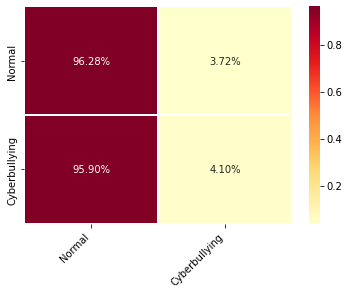

lstm_random_over
              precision    recall  f1-score   support

           0       0.92      0.85      0.89     10241
           1       0.29      0.45      0.35      1343

    accuracy                           0.81     11584
   macro avg       0.61      0.65      0.62     11584
weighted avg       0.85      0.81      0.82     11584



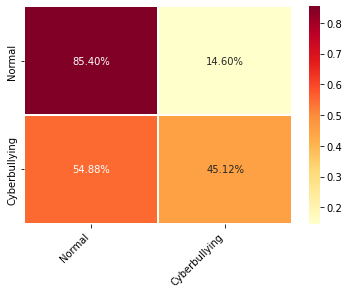

lstm_glove
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     10241
           1       0.72      0.73      0.73      1343

    accuracy                           0.94     11584
   macro avg       0.84      0.85      0.85     11584
weighted avg       0.94      0.94      0.94     11584



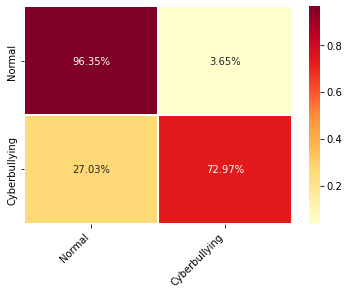

lstm_glove_over
              precision    recall  f1-score   support

           0       0.97      0.94      0.96     10241
           1       0.63      0.79      0.70      1343

    accuracy                           0.92     11584
   macro avg       0.80      0.87      0.83     11584
weighted avg       0.93      0.92      0.93     11584



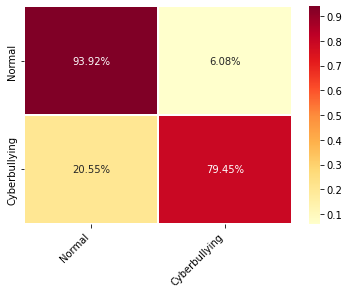

lstm_word2vec
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     10241
           1       0.76      0.68      0.72      1343

    accuracy                           0.94     11584
   macro avg       0.86      0.83      0.84     11584
weighted avg       0.94      0.94      0.94     11584



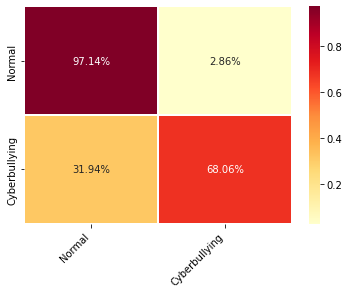

lstm_word2vec_over
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     10241
           1       0.72      0.75      0.73      1343

    accuracy                           0.94     11584
   macro avg       0.84      0.85      0.85     11584
weighted avg       0.94      0.94      0.94     11584



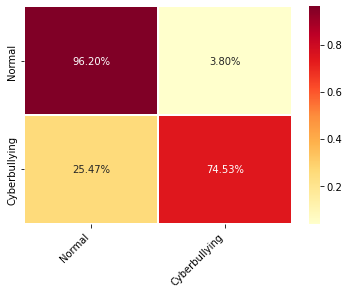

blstm_random
              precision    recall  f1-score   support

           0       0.97      0.54      0.70     10241
           1       0.20      0.88      0.33      1343

    accuracy                           0.58     11584
   macro avg       0.59      0.71      0.51     11584
weighted avg       0.88      0.58      0.65     11584



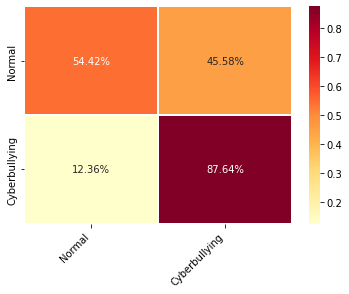

blstm_random_over
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     10241
           1       0.55      0.46      0.50      1343

    accuracy                           0.89     11584
   macro avg       0.74      0.71      0.72     11584
weighted avg       0.89      0.89      0.89     11584



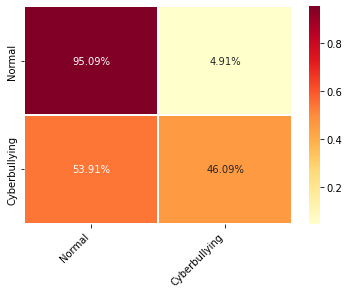

blstm_glove
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     10241
           1       0.73      0.74      0.73      1343

    accuracy                           0.94     11584
   macro avg       0.85      0.85      0.85     11584
weighted avg       0.94      0.94      0.94     11584



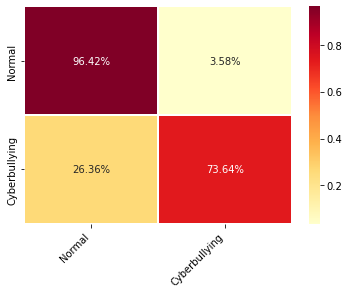

blstm_glove_over
              precision    recall  f1-score   support

           0       0.97      0.94      0.96     10241
           1       0.63      0.79      0.70      1343

    accuracy                           0.92     11584
   macro avg       0.80      0.87      0.83     11584
weighted avg       0.93      0.92      0.93     11584



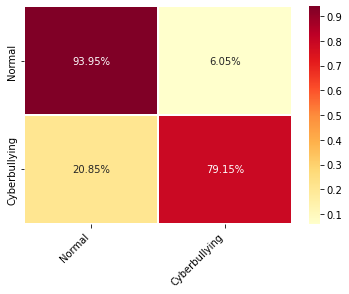

blstm_word2vec
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     10241
           1       0.74      0.71      0.72      1343

    accuracy                           0.94     11584
   macro avg       0.85      0.84      0.84     11584
weighted avg       0.94      0.94      0.94     11584



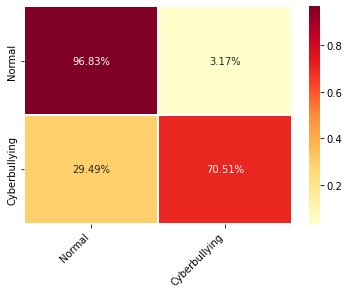

blstm_word2vec_over
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     10241
           1       0.71      0.73      0.72      1343

    accuracy                           0.93     11584
   macro avg       0.84      0.85      0.84     11584
weighted avg       0.94      0.93      0.93     11584



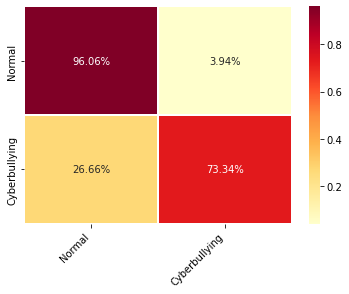

blstm_att_random
              precision    recall  f1-score   support

           0       0.99      0.40      0.57     10241
           1       0.17      0.96      0.29      1343

    accuracy                           0.46     11584
   macro avg       0.58      0.68      0.43     11584
weighted avg       0.89      0.46      0.54     11584



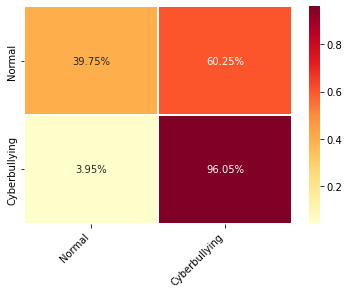

blstm_att_random_over
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     10241
           1       0.92      0.08      0.14      1343

    accuracy                           0.89     11584
   macro avg       0.91      0.54      0.54     11584
weighted avg       0.90      0.89      0.85     11584



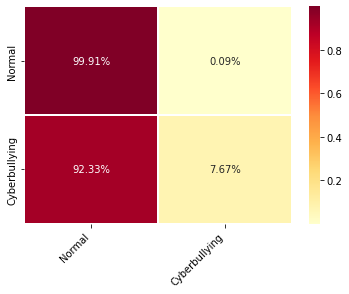

blstm_att_glove
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     10241
           1       0.72      0.71      0.72      1343

    accuracy                           0.94     11584
   macro avg       0.84      0.84      0.84     11584
weighted avg       0.93      0.94      0.94     11584



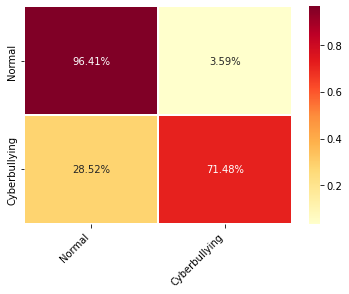

blstm_att_glove_over
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     10241
           1       0.69      0.75      0.72      1343

    accuracy                           0.93     11584
   macro avg       0.83      0.85      0.84     11584
weighted avg       0.93      0.93      0.93     11584



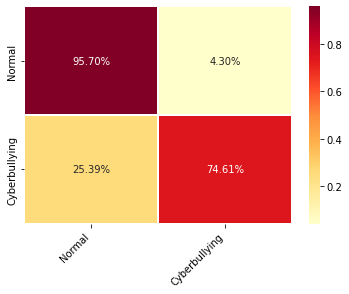

blstm_att_word2vec
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     10241
           1       0.77      0.69      0.73      1343

    accuracy                           0.94     11584
   macro avg       0.86      0.83      0.85     11584
weighted avg       0.94      0.94      0.94     11584



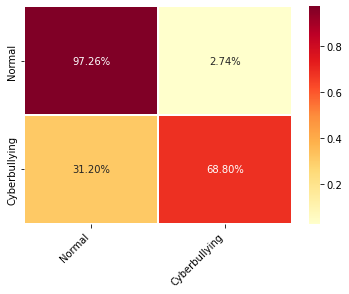

blstm_att_word2vec_over
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     10241
           1       0.67      0.76      0.71      1343

    accuracy                           0.93     11584
   macro avg       0.82      0.86      0.84     11584
weighted avg       0.93      0.93      0.93     11584



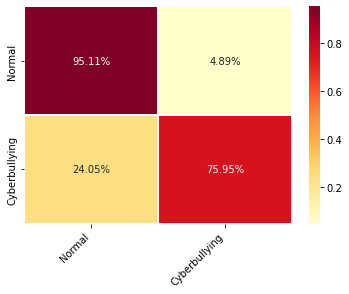

cnn_random
              precision    recall  f1-score   support

           0       0.96      0.91      0.94     10241
           1       0.52      0.72      0.60      1343

    accuracy                           0.89     11584
   macro avg       0.74      0.82      0.77     11584
weighted avg       0.91      0.89      0.90     11584



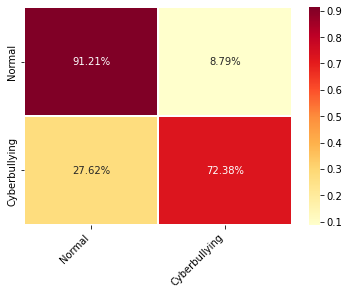

cnn_random_over
              precision    recall  f1-score   support

           0       0.95      0.96      0.96     10241
           1       0.68      0.62      0.65      1343

    accuracy                           0.92     11584
   macro avg       0.81      0.79      0.80     11584
weighted avg       0.92      0.92      0.92     11584



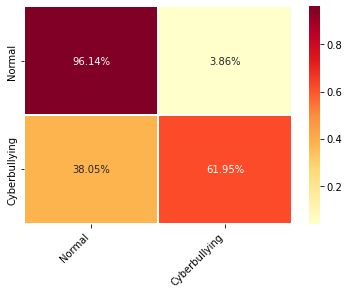

cnn_glove
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     10241
           1       0.78      0.66      0.71      1343

    accuracy                           0.94     11584
   macro avg       0.87      0.82      0.84     11584
weighted avg       0.94      0.94      0.94     11584



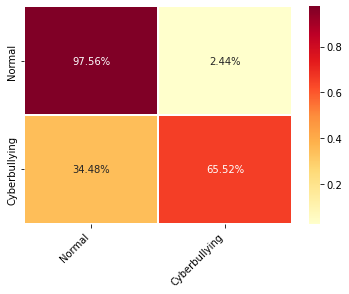

cnn_glove_over
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     10241
           1       0.67      0.75      0.71      1343

    accuracy                           0.93     11584
   macro avg       0.82      0.85      0.83     11584
weighted avg       0.93      0.93      0.93     11584



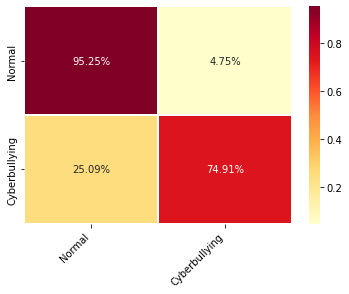

cnn_word2vec
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     10241
           1       0.79      0.68      0.73      1343

    accuracy                           0.94     11584
   macro avg       0.87      0.83      0.85     11584
weighted avg       0.94      0.94      0.94     11584



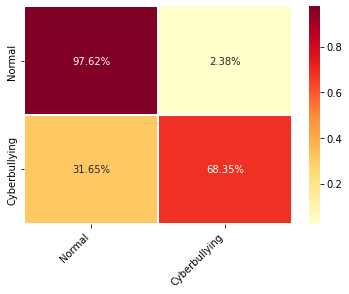

cnn_word2vec_over
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     10241
           1       0.71      0.79      0.75      1343

    accuracy                           0.94     11584
   macro avg       0.84      0.87      0.86     11584
weighted avg       0.94      0.94      0.94     11584



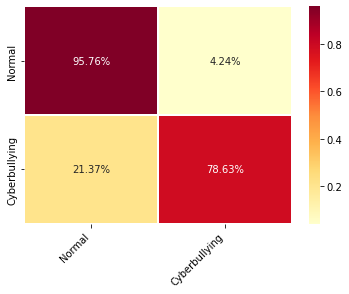

In [ ]:
predictions = []

for model in model_list:
    index = model_list.index(model)
    print(model_name_list[index])
    model_prediction = indiv_eval(model, X_test, y_test)
    predictions.append(model_prediction)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.88      1.00      0.94     10241
           1       0.00      0.00      0.00      1343

    accuracy                           0.88     11584
   macro avg       0.44      0.50      0.47     11584
weighted avg       0.78      0.88      0.83     11584



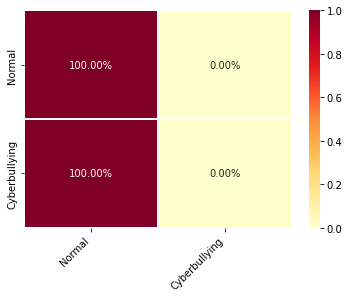

In [27]:
model_prediction_autochar = indiv_eval(automl_model, X_test, y_test)

In [ ]:
import joblib
joblib.dump(predictions, '/content/drive/MyDrive/Uni/Experiment Design/Ass2/Deep Learning/wiki_dl_preds.df')

['/content/drive/MyDrive/Uni/Experiment Design/Ass2/Deep Learning/wiki_dl_preds.df']

In [ ]:
import joblib
predictions = joblib.load('/content/drive/MyDrive/Uni/Experiment Design/Ass2/Deep Learning/wiki_dl_preds.df')

In [ ]:
predictions.append(model_prediction_autochar)
predictions.append(model_prediction_autoword)

In [ ]:
multiple_mcnemar(model_name_list, predictions, y_test, 0.01)

+-------------------------+-------------------------+-----------+------------+---------+
|         Model 1         |         Model 2         |    Chi²   |  p-Value   | Reject? |
+-------------------------+-------------------------+-----------+------------+---------+
|       lstm_random       |     lstm_random_over    | 1.28E+02f | 1.36E-29f  |   True  |
|       lstm_random       |        lstm_glove       | 5.21E+02f | 2.71E-115f |   True  |
|       lstm_random       |     lstm_glove_over     | 2.98E+02f | 1.01E-66f  |   True  |
|       lstm_random       |      lstm_word2vec      | 5.84E+02f | 5.68E-129f |   True  |
|       lstm_random       |    lstm_word2vec_over   | 5.16E+02f | 3.39E-114f |   True  |
|       lstm_random       |       blstm_random      | 1.65E+03f | 0.00E+00f  |   True  |
|       lstm_random       |    blstm_random_over    | 1.29E+02f | 6.90E-30f  |   True  |
|       lstm_random       |       blstm_glove       | 5.31E+02f | 1.48E-117f |   True  |
|       lstm_random  